# Convolution Neural Networks
In this tutorial we will implement [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) on MNIST. LeNet is one of the first successfull convolution networks used of hadwritten digit recognition, developed by Yann LeCun in 1990’s. It has 7 layers (not counting the input layer) with the following description:
 * Input: Image with shape 28\*28\*1
 
 * C1: Convolutional layer with 6 feature maps. Each uint in each feature map is connected to a 5\*5 neighborhood in the input
 
 * S2: Subsampling (pooling) layer with 6 feature maps of size 14\*14. Each node in each feature map is connected to a 2\*2 neighborhood in the C1
 
 * C3: Convolutional layer with 16 feature maps. Each node in each feature map is connected to a 5\*5 neighborhood in the S2
 
 * S4: Subsampling (pooling) layer with 16 feature maps of size 5\*5. Each node in each feature map is connected to a 2\*2 neighborhood in the C3
 
 * C5: Convolutional layer with 120 feature maps. Each node in each feature map is connected to a 5\*5 neighborhood in the S4
 
 * F6: Fully connected layer with 84 node fully connected to the C5
 
 * Output: 10 node for classification of digits (0-9)
 
<img src="files/files/lenet.png">



## Imports

In [1]:
%matplotlib inline 

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Load dataset
Thankfully, tensorflow made everything easy for us. You can easily load the mnist data from the Tensorflow as follows:

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Define hyperparameters


In [3]:
learning_rate = 0.001
training_iters = 1000
batch_size = 128
display_step = 50

# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)
dropout_val = 0.75  # Dropout, probability to keep units



## Create functions to initialize weights and biases variables

In [4]:
def weight_variable(name, shape):
    """
    Create a weight variable with appropriate initialization
    name: weight name
    shape: weight shape
    
    return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W_' + name, 
                           dtype=tf.float32,
                           shape=shape, 
                           initializer=initer)


def bias_variable(name, shape):
    """
    Create a bias variable with appropriate initialization
    name: bias variable name
    shape: bias variable shape
    
    return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name, 
                           dtype=tf.float32,
                           initializer=initial)

## Create functions to build different layers

In [5]:
def conv_layer(x, num_filters, filter_size, stride, name):
    """
    Create a 2D convolution layer
    inputs: input array
    filter_size: size of the filter
    stride: filter stride
    num_filters: number of filters (or output feature maps)
    name: layer name
    return: The output array
    """
    num_in_channel = x.get_shape().as_list()[-1]

    shape = [filter_size, filter_size, num_in_channel, num_filters]
    W = weight_variable(name, shape=shape)
    b = bias_variable(name, [num_filters])

    layer = tf.nn.conv2d(x, W,
                     strides=[1, stride, stride, 1],
                     padding="SAME")
    layer += b
        
    return tf.nn.relu(layer)

def max_pool(x, ksize, stride, name):
    """
    Create a max pooling layer
    :param x: input to max-pooling layer
    :param ksize: size of the max-pooling filter
    :param stride: stride of the max-pooling filter
    :param name: layer name
    :return: The output array
    """
    layer = tf.nn.max_pool(x,
                             ksize=[1, ksize, ksize, 1],
                             strides=[1, stride, stride, 1],
                             padding="SAME",
                             name=name)
    return layer

def fc_layer(x, num_nodes, name, use_relu=True):
    """
    Creates a fully-connected layer
    :param x: input from previous layer
    :param num_nodes: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    
    :return: The output array
    """
    in_dim = x.get_shape()[1]
    W = weight_variable(name, shape=[in_dim, num_nodes])
    b = bias_variable(name, [num_nodes])
    layer = tf.matmul(x, W)
    layer += b
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

def flatten_layer(layer):
    """
    Flattens the output of the convolutional layer to be fed into fully-connected layer
    :param layer: input array
    :return: flattened array
    """
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat

def dropout(x, keep_prob):
    """
    Create a dropout layer
    :param x: input to dropout layer
    :param keep_prob: dropout rate (e.g.: 0.5 means keeping 50% of the units)
    :return: the output array
    """
    return tf.nn.dropout(x, keep_prob)

## Create the graph

In [6]:
# Placeholders for inputs (x), outputs(y) and dropout(keep_prob)
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)


def LeNet(x, n_classes, keep_prob):
    """
    Create LeNet Model
    :param x: input to the netwoks
    :param n_classes: number of output units (classes)
    :param keep_prob: dropout rate (e.g.: 0.5 means keeping 50% of the units)
    :return: the output array
    """
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    C1 = conv_layer(x, 6, 5, 1, 'C1')
    S2 = max_pool(C1, 2, 2, 'S2')
    C3 = conv_layer(S2, 16, 5, 1,  'C3')
    S4 = max_pool(C3, 2, 2, 'S4')
    C5 = conv_layer(S4, 120, 5, 1, 'C5')
    C5 = flatten_layer(C5)
    F6 = fc_layer(C5, 84, 'F6', use_relu=True)
    F6 = dropout(F6, keep_prob)
    out = fc_layer(F6, n_classes, 'FC2', use_relu=False)
    return out

# Build our model
output_scores = LeNet(x, n_classes, keep_prob)

# Define loss, optimizer, accuracy for training
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_scores))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
correct_prediction = tf.equal(tf.argmax(output_scores, 1), tf.argmax(y, 1))
accuracy =  tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# predict classes for testing and evluation
predicted_classes = tf.argmax(output_scores, axis=1)

# predicted_prob = tf.nn.softmax(output_scores)


# Initializing the variables
init = tf.global_variables_initializer()

## Run the graph in session

Iter 0, Loss= 2.30, Training Accuracy= 0.18
Iter 50, Loss= 0.72, Training Accuracy= 0.78
Iter 100, Loss= 0.47, Training Accuracy= 0.86
Iter 150, Loss= 0.38, Training Accuracy= 0.88
Iter 200, Loss= 0.21, Training Accuracy= 0.94
Iter 250, Loss= 0.23, Training Accuracy= 0.93
Iter 300, Loss= 0.17, Training Accuracy= 0.95
Iter 350, Loss= 0.08, Training Accuracy= 0.97
Iter 400, Loss= 0.21, Training Accuracy= 0.96
Iter 450, Loss= 0.13, Training Accuracy= 0.97
Iter 500, Loss= 0.06, Training Accuracy= 0.98
Iter 550, Loss= 0.08, Training Accuracy= 0.97
Iter 600, Loss= 0.20, Training Accuracy= 0.92
Iter 650, Loss= 0.09, Training Accuracy= 0.98
Iter 700, Loss= 0.08, Training Accuracy= 0.98
Iter 750, Loss= 0.09, Training Accuracy= 0.95
Iter 800, Loss= 0.11, Training Accuracy= 0.98
Iter 850, Loss= 0.13, Training Accuracy= 0.97
Iter 900, Loss= 0.11, Training Accuracy= 0.96
Iter 950, Loss= 0.06, Training Accuracy= 0.99
Testing Accuracy: 0.988281


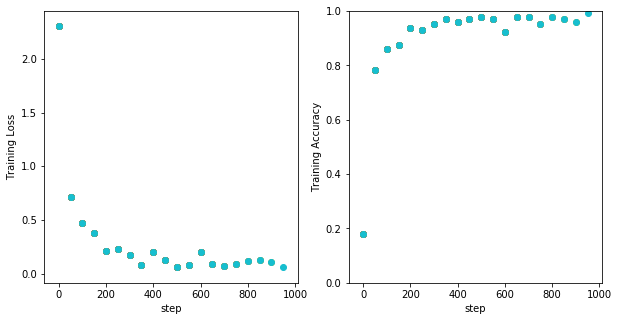

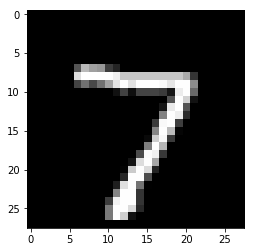

Model prediction: 7


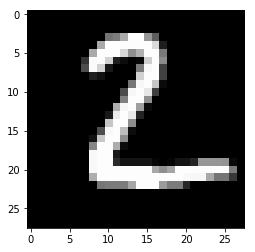

Model prediction: 2


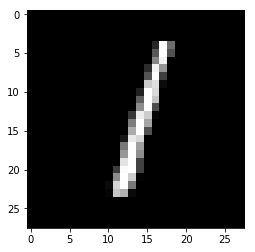

Model prediction: 1


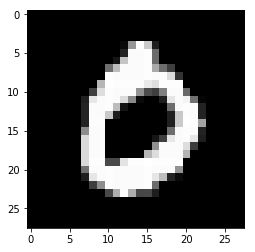

Model prediction: 0


In [7]:
# make a figure to show the loss
def makeFig(ax, xlist, ylist):
    ax.scatter(xlist, ylist)
    
# creating the figure and adjusting its settings
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
plt.ion()  # enable interactivity
fig.set_size_inches(10, 5)
ax0 = axs[0]
ax0.set_ylabel('Training Loss')
ax0.set_xlabel('step')
ax1 = axs[1]
ax1.set_ylim([0, 1])
ax1.set_ylabel('Training Accuracy')
ax1.set_xlabel('step')

xList = list()
lossList = list()
accList = list()


# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # Keep training until reach max iterations
    for step in range(training_iters):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        # Run optimization op (backprop)
        _, loss_batch, acc = sess.run([optimizer, loss, accuracy],
                                feed_dict={x: batch_x, y: batch_y, keep_prob: dropout_val})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print("Iter " + str(step) + 
                  ", Loss= " + "{:.2f}".format(loss_batch) + 
                  ", Training Accuracy= " + "{:.2f}".format(acc_batch))
            
            xList.append(step)
            lossList.append(loss_batch)
            accList.append(acc_batch)
            # Plot loss
            makeFig(ax0, xList, lossList)
            # plt.draw()
            plt.pause(0.001)
            # Plot accuracy
            makeFig(ax1, xList, accList)
            plt.draw()

    

    # test the network
    # Calculate accuracy
    print("Testing Accuracy:",
          sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
                                        y: mnist.test.labels[:256],
                                        keep_prob: 1.}))
    # Predict single images
    n_images = 4
    test_images = mnist.test.images[:n_images]
    preds = sess.run(predicted_classes, feed_dict={x: test_images,
                                            keep_prob: 1.})
    # Display
    for i in range(n_images):
        plt.figure()
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
        plt.show()
        print("Model prediction:", preds[i])
